# Comparison of MLP and Bayes NN on Diabetest dataset

### Importing libraries

In [117]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import zhusuan as zs

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

tf.set_random_seed(123)
np.random.seed(321)

### Load data

In [118]:
X_, y_ = load_diabetes(return_X_y=True)
train_X, test_X, train_y, test_y = train_test_split(X_, y_, test_size=.2, random_state=42)

n_train, x_dim = train_X.shape
n_test = test_X.shape[0]
y_dim = 1

train_X.shape, train_y.shape, test_X.shape, test_y.shape

((353, 10), (353,), (89, 10), (89,))

### Standarize data

In [119]:
def standardize(data_train, data_test):
    """
    Standardize a dataset to have zero mean and unit standard deviation.

    :param data_train: 2-D Numpy array. Training data.
    :param data_test: 2-D Numpy array. Test data.

    :return: (train_set, test_set, mean, std), The standardized dataset and
        their mean and standard deviation before processing.
    """
    std = np.std(data_train, 0, keepdims=True)
    std[std == 0] = 1
    mean = np.mean(data_train, 0, keepdims=True)
    data_train_standardized = (data_train - mean) / std
    data_test_standardized = (data_test - mean) / std
    mean, std = np.squeeze(mean, 0), np.squeeze(std, 0)
    return data_train_standardized, data_test_standardized, mean, std

In [120]:
train_X_standard, test_X_standard, _, _ = standardize(train_X, test_X)
train_y_standard, test_y_standard, _, std_y_train = standardize(train_y, test_y)

### Defintion of parameters

In [121]:
n_hiddens = [64, 32]
layer_sizes = [x_dim] + n_hiddens + [y_dim]

epochs = 50
lr = 0.005
batch_size = 100 

### MLP model

In [122]:
mlp = Sequential()
mlp.add(Dense(layer_sizes[1], activation="relu", input_shape=(x_dim,)))
for out_dim in layer_sizes[2:-1]:
    mlp.add(Dense(out_dim, activation="relu"))
mlp.add(Dense(y_dim, activation="linear"))

optimizer = Adam(lr=lr)
mlp.compile(
    loss="mean_squared_error", optimizer=optimizer, metrics=["mean_squared_error"]
)
mlp.build()
mlp.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
_________________________________________________________________


In [123]:
training_results = mlp.fit(
                            x=train_X_standard,
                            y=train_y_standard,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(test_X_standard, test_y_standard),
                        )

Train on 353 samples, validate on 89 samples
Epoch 1/50
353/353 [==============================] - 0s 1ms/sample - loss: 1.1464 - mean_squared_error: 1.1464 - val_loss: 0.5749 - val_mean_squared_error: 0.5749
Epoch 2/50
353/353 [==============================] - 0s 36us/sample - loss: 0.5924 - mean_squared_error: 0.5924 - val_loss: 0.5836 - val_mean_squared_error: 0.5836
Epoch 3/50
353/353 [==============================] - 0s 31us/sample - loss: 0.5428 - mean_squared_error: 0.5428 - val_loss: 0.5100 - val_mean_squared_error: 0.5100
Epoch 4/50
353/353 [==============================] - 0s 33us/sample - loss: 0.4665 - mean_squared_error: 0.4665 - val_loss: 0.4873 - val_mean_squared_error: 0.4873
Epoch 5/50
353/353 [==============================] - 0s 28us/sample - loss: 0.4537 - mean_squared_error: 0.4537 - val_loss: 0.4780 - val_mean_squared_error: 0.4780
Epoch 6/50
353/353 [==============================] - 0s 29us/sample - loss: 0.4401 - mean_squared_error: 0.4401 - val_loss: 0.4617

In [124]:
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):
    fig, ax = plt.subplots(figsize=(15, 4))
    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    # plt.xlim([0, 20])
    # plt.ylim(ylim)
    # Tailor x-axis tick marks
    # ax.xaxis.set_major_locator(MultipleLocator(5))
    # ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    # ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show()
    plt.close()

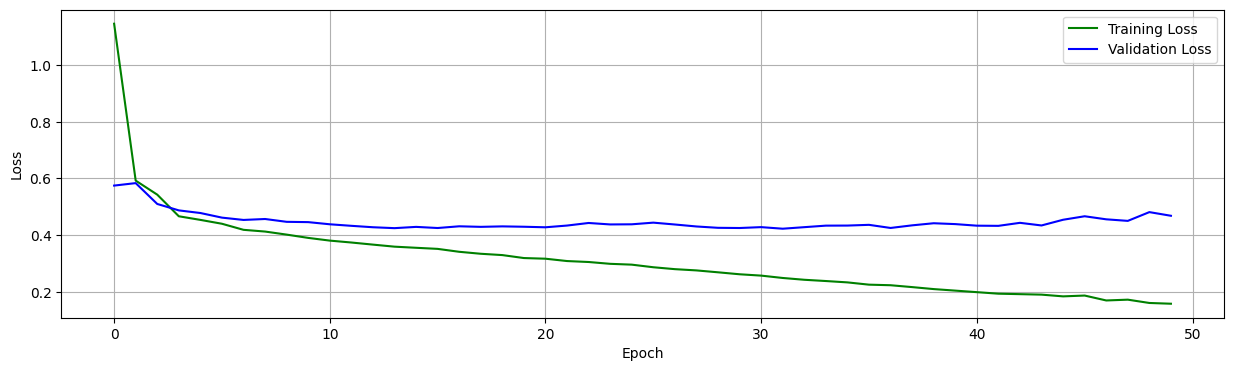

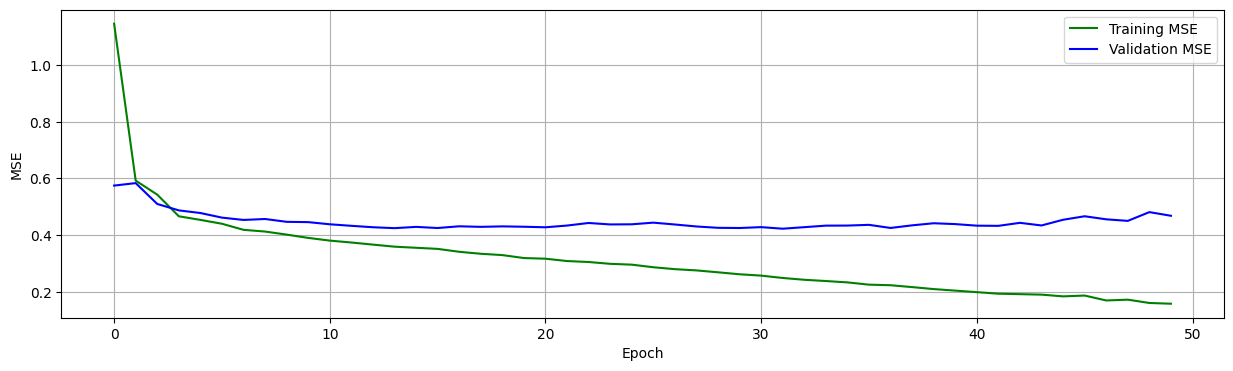

In [125]:
train_loss = training_results.history["loss"]
valid_loss = training_results.history["val_loss"]
train_acc  = training_results.history["mean_squared_error"]
valid_acc  = training_results.history["val_mean_squared_error"]

plot_results([ train_loss, valid_loss ],        
            ylabel="Loss", 
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"]);

plot_results([ train_acc, valid_acc ], 
            ylabel="MSE",
            metric_name=["Training MSE", "Validation MSE"],
            color=["g", "b"])

### Bayes NN model

In [126]:
lr=0.08

In [127]:
@zs.meta_bayesian_net(scope="bnn", reuse_variables=True)
def build_bnn(x, layer_sizes, n_particles):
    bn = zs.BayesianNet()
    h = tf.tile(x[None, ...], [n_particles, 1, 1])
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w = bn.normal("w" + str(i), tf.zeros([n_out, n_in + 1]), std=1.,
                      group_ndims=2, n_samples=n_particles)
        h = tf.concat([h, tf.ones(tf.shape(h)[:-1])[..., None]], -1)
        h = tf.einsum("imk,ijk->ijm", w, h) / tf.sqrt(
            tf.cast(tf.shape(h)[2], tf.float32))
        if i < len(layer_sizes) - 2:
            h = tf.nn.relu(h)

    y_mean = bn.deterministic("y_mean", tf.squeeze(h, 2))
    y_logstd = tf.get_variable("y_logstd", shape=[],
                               initializer=tf.constant_initializer(0.))
    bn.normal("y", y_mean, logstd=y_logstd)
    return bn

In [128]:
@zs.reuse_variables(scope="variational")
def build_mean_field_variational(layer_sizes, n_particles):
    bn = zs.BayesianNet()
    for i, (n_in, n_out) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        w_mean = tf.get_variable(
            "w_mean_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        w_logstd = tf.get_variable(
            "w_logstd_" + str(i), shape=[n_out, n_in + 1],
            initializer=tf.constant_initializer(0.))
        bn.normal("w" + str(i), w_mean, logstd=w_logstd,
                  n_samples=n_particles, group_ndims=2)
    return bn

In [129]:
n_particles = tf.placeholder(tf.int32, shape=[], name="n_particles")
x = tf.placeholder(tf.float32, shape=[None, x_dim])
y = tf.placeholder(tf.float32, shape=[None])
w_names = ["w" + str(i) for i in range(len(layer_sizes) - 1)]

In [130]:
model = build_bnn(x, layer_sizes, n_particles)
variational = build_mean_field_variational(layer_sizes, n_particles)

def log_joint(bn):
    log_pws = bn.cond_log_prob(w_names)
    log_py_xw = bn.cond_log_prob('y')
    return tf.add_n(log_pws) + tf.reduce_mean(log_py_xw, 1) * n_train

model.log_joint = log_joint

lower_bound = zs.variational.elbo(
    model, {'y': y}, variational=variational, axis=0)
cost = lower_bound.sgvb()

optimizer = tf.train.AdamOptimizer(learning_rate=lr)
infer_op = optimizer.minimize(cost)

In [131]:
y_mean = lower_bound.bn["y_mean"]
y_pred = tf.reduce_mean(y_mean, 0)
y_true = y
se = tf.reduce_sum((y_pred - y_true) ** 2)
log_py_xw = lower_bound.bn.cond_log_prob("y")
log_likelihood = tf.reduce_mean(zs.log_mean_exp(log_py_xw, 0)) - tf.log(tf.cast(std_y_train, tf.float32))

In [132]:
lb_samples = 10
ll_samples = 5000
epochs = 50
batch_size = 20
iters = (n_train-1) // batch_size + 1
test_batch_size = 100
test_iters = (n_test-1) // batch_size + 1
test_freq = 1

In [133]:
# Run the inference
train_mses = []
test_mses= []

train_lbs = []
test_lbs = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(1, epochs + 1):
        perm = np.random.permutation(train_X_standard.shape[0])
        train_X_standard = train_X_standard[perm, :]
        train_y_standard = train_y_standard[perm]
        lbs = []
        ses = 0
        for t in range(iters):
            x_batch = train_X_standard[t * batch_size:(t + 1) * batch_size]
            y_batch = train_y_standard[t * batch_size:(t + 1) * batch_size]
            if len(x_batch) == 0:
                continue
            _, lb = sess.run(
                [infer_op, lower_bound],
                feed_dict={n_particles: lb_samples,
                           x: x_batch, y: y_batch})
            lbs.append(lb)
            train_se = sess.run(
                [se],
                feed_dict={n_particles: ll_samples,
                            x: x_batch, y: y_batch})
            ses += train_se[0]
        train_mses.append(ses / n_train)

        train_lb = np.mean(lbs)
        train_lbs.append(train_lb)
        print('Epoch {}: Lower bound = {};'.format(epoch, train_lb))

        if epoch % test_freq == 0:
            lbs = []
            ses = 0
            for t in range(iters):
                x_batch = test_X_standard[t * test_batch_size:(t + 1) * test_batch_size]
                y_batch = test_y_standard[t * test_batch_size:(t + 1) * test_batch_size]
                if len(x_batch) == 0:
                    continue
                test_se = sess.run(
                    [se],
                    feed_dict={n_particles: ll_samples,
                                x: x_batch, y: y_batch})
                ses += test_se[0]
                # test_lb = sess.run(
                #     [lower_bound],
                #     feed_dict={n_particles: lb_samples,
                #             x: x_batch, y: y_batch})
                # lbs.append(test_lb)
            # test_lbs.append(np.mean(lbs))
            test_mses.append(ses / n_test)
            
            # print('>> TEST')
            # print('>> Test mse = {}, log_likelihood = {}'.format(test_mse, test_ll))

Epoch 1: Lower bound = -605.6065673828125;
Epoch 2: Lower bound = -576.9207763671875;
Epoch 3: Lower bound = -577.704345703125;
Epoch 4: Lower bound = -570.8287353515625;
Epoch 5: Lower bound = -576.5200805664062;
Epoch 6: Lower bound = -574.1132202148438;
Epoch 7: Lower bound = -578.3636474609375;
Epoch 8: Lower bound = -576.1107788085938;
Epoch 9: Lower bound = -567.9082641601562;
Epoch 10: Lower bound = -569.815673828125;
Epoch 11: Lower bound = -569.520263671875;
Epoch 12: Lower bound = -583.717529296875;
Epoch 13: Lower bound = -580.4231567382812;
Epoch 14: Lower bound = -553.8297119140625;
Epoch 15: Lower bound = -564.9830932617188;
Epoch 16: Lower bound = -560.7125244140625;
Epoch 17: Lower bound = -555.6834106445312;
Epoch 18: Lower bound = -561.5548095703125;
Epoch 19: Lower bound = -551.776123046875;
Epoch 20: Lower bound = -555.5200805664062;
Epoch 21: Lower bound = -550.247314453125;
Epoch 22: Lower bound = -570.4390258789062;
Epoch 23: Lower bound = -547.5180053710938;
Epo

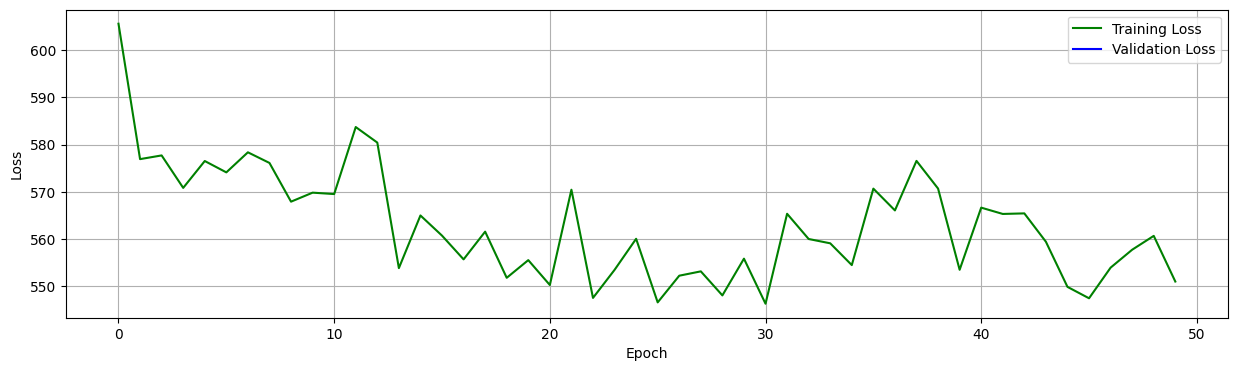

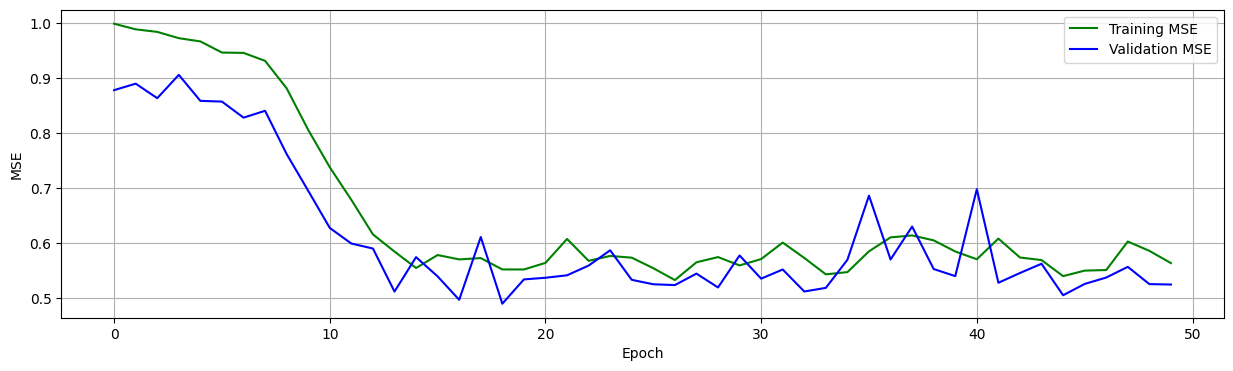

In [134]:
plot_results([ np.abs(train_lbs), np.abs(test_lbs) ],
            ylabel="Loss",
            metric_name=["Training Loss", "Validation Loss"],
            color=["g", "b"])

plot_results([ train_mses, test_mses ],
            ylabel="MSE",
            metric_name=["Training MSE", "Validation MSE"],
            color=["g", "b"])